In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
import codecs

In [6]:
connection = sqlite3.connect('../OpenStudio_Models/Office_Austin/run/eplusout.sql')

data_sql = """
    select KeyValue, VariableName, VariableValue, SimulationDays
    from ReportVariableData
    inner join ReportVariableDataDictionary
        on ReportVariableDataDictionary.ReportVariableDataDictionaryIndex = ReportVariableData.ReportVariableDataDictionaryIndex
    inner join Time
        on Time.TimeIndex = ReportVariableData.TimeIndex
    where ReportingFrequency == 'Hourly'
"""
raw_df = pd.read_sql(data_sql, connection)

In [67]:
df = raw_df.pivot_table(values='VariableValue', index=['SimulationDays'], columns=['KeyValue','VariableName'])

display(df.head())

KeyValue                                           \
VariableName   Electricity:Facility  Gas:Facility   
SimulationDays                                      
1                      2.411308e+07  99776.118324   
2                      6.265338e+07  11694.054185   
3                      6.224943e+07      0.000000   
4                      6.225566e+07  18128.558065   
5                      6.242283e+07   4852.484926   

KeyValue       ADU AIR TERMINAL SINGLE DUCT UNCONTROLLED 1  \
VariableName     Zone Air Terminal Sensible Cooling Energy   
SimulationDays                                               
1                                             3.531612e+05   
2                                             2.979946e+07   
3                                             2.599090e+07   
4                                             2.771707e+07   
5                                             2.833287e+07   

KeyValue                                                \
VariableName   Zone Air Terminal Sensible Cooling Rate   
SimulationDays                                           
1                                           588.601970   
2                                         50414.355666   
3                                         43318.171761   
4                                         47401.768805   
5                                         48501.992774   

KeyValue                                                  \
VariableName   Zone Air Terminal Sensible Heating Energy   
SimulationDays                                             
1                                           1.817987e+06   
2                                           8.688315e+05   
3                                           1.006817e+06   
4                                           9.721643e+05   
5                                           9.554596e+05   

KeyValue                                                \
VariableName   Zone Air Terminal Sensible Heating Rate   
SimulationDays                                           
1                                          3029.977854   
2                                          1452.988978   
3                                          1678.028372   
4                                          1681.968929   
5                                          1594.757177   

KeyValue                           AIR LOOP HVAC 1  \
VariableName   Air System Mixed Air Mass Flow Rate   
SimulationDays                                       
1                                         1.993383   
2                                         1.993383   
3                                         1.993383   
4                                         1.993383   
5                                         1.993383   

KeyValue                                                 \
VariableName   Air System Outdoor Air Economizer Status   
SimulationDays                                            
1                                                   0.0   
2                                                   0.0   
3                                                   0.0   
4                                                   0.0   
5                                                   0.0   

KeyValue                                             \
VariableName   Air System Outdoor Air Flow Fraction   
SimulationDays                                        
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
5                                               0.0   

KeyValue                                                                                 \
VariableName   Air System Outdoor Air Heat Recovery Bypass Heating Coil Activity Status   
SimulationDays                                                                            
1                                              

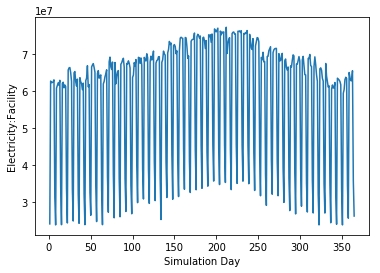

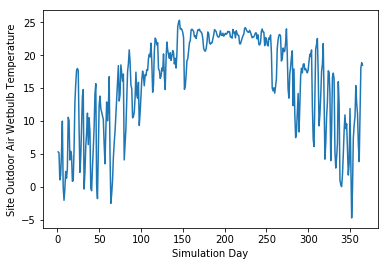

In [68]:
def plot_variable(keyValue, varName):
    ax = plt.subplot(1,1,1)
    p1, = ax.plot(df.index.values, df[keyValue][varName])
    ax.set_xlabel("Simulation Day")
    ax.set_ylabel(varName)
    plt.show()

plot_variable("", "Electricity:Facility")
plot_variable("Environment", "Site Outdoor Air Wetbulb Temperature")

In [69]:
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

X_train = df.drop(("", "Electricity:Facility"), axis=1)
y = df["", "Electricity:Facility"]

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=5).fit(X_train, y)

rmse_cv(model_lasso).mean()
# plt.plot(X_train.index.values, model_lasso.predict(X_train))

157925.64526046062

Lasso picked 307 variables and eliminated the other 428 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

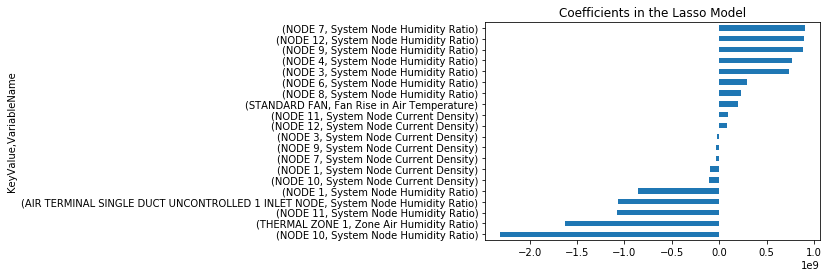

In [70]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [3]:
connection = sqlite3.connect('../OpenStudio_Models/Office_Michigan/run/eplusout.sql')

raw_df = pd.read_sql(data_sql, connection)
df_mich = raw_df.pivot_table(values='VariableValue', index=['SimulationDays'], columns=['KeyValue','VariableName'])

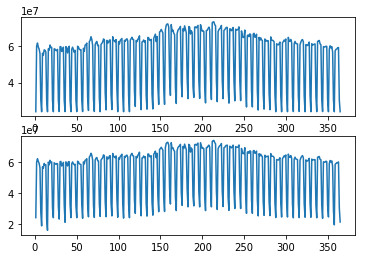

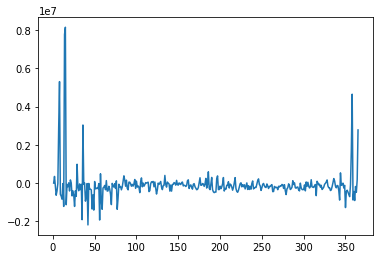

In [77]:
X_test = df_mich.drop(("", "Electricity:Facility"), axis=1)

y_true = df_mich["", "Electricity:Facility"]
y_pred = model_lasso.predict(X_test)

_, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(df_mich.index.values, y_true)
ax2.plot(df_mich.index.values, y_pred)

plt.figure()
plt.plot(df_mich.index.values, y_true - y_pred)